## Test two GLMM algorithms 

In [29]:
using Revise, DelimitedFiles

In [34]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating environment at `~/GIT/susie-glmm/SuSiEGLMM.jl/Project.toml`


In [66]:
@__DIR__

"/Users/jeankim/GIT/susie-glmm/SuSiEGLMM.jl/test"

In [53]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM

In [64]:
using SuSiEGLMM

In [37]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

  0.624938 seconds (5.98 M allocations: 209.878 MiB, 14.15% gc time, 15.12% compilation time)


In [38]:
# pedgree grm and grm
K=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm_ped.txt"); #518
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

In [122]:
Seed(124)

## Sampling one dataset for comparison

In [41]:
X1= (X.-mean(X,dims=2))./std(X,dims=2)
n,p = size(X1)
L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 

# Ts=zeros(p,B);Ts1=zeros(p,B);

In [115]:
(n,p)

(503, 4000)

In [117]:
τ2=0.1; #true value

# res0=[]; res1=[]

# K=Matrix(1.0I,n,n)
# T,S = svdK(K;LOCO=false) #pedigree
T,S = svdK(K0;LOCO=false) #grm

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787221 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479865 … 0.001685475850207209 -0.020019442310487214; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

## GLMM (no integration out of fixed effects but corrected version)

In [123]:
# for j = 1:B
    b_true[1]= randn(1)[1] 
#     b_1s[j] = b_true[1]   
   
#     X=randn(n,p)
#     g=rand(MvNormal(τ2*K)) #pedigree grm
    g=rand(MvNormal(τ2*K0)) #grm
    
    #generating binary outcome
    Y= logistic.(g) .>rand(n); Y=convert(Vector{Float64},Y);
    Y1=logistic.(X1*b_true+g) .>rand(n);  Y1=convert(Vector{Float64},Y1);
       
    X₀=ones(n,1);

In [124]:
   
   # transforming data         
     Xt, Xt₀, y0 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
       y1= SuSiEGLMM.rotateY(Y1,T)

#initialization
    τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

26-element Vector{Float64}:
 0.0009765625
 0.0013810679320049757
 0.001953125
 0.0027621358640099515
 0.00390625
 0.005524271728019903
 0.0078125
 0.011048543456039806
 0.015625
 0.02209708691207961
 0.03125
 0.04419417382415922
 0.0625
 0.08838834764831845
 0.125
 0.1767766952966369
 0.25
 0.3535533905932738
 0.5
 0.7071067811865476
 1.0
 1.4142135623730951
 2.0
 2.8284271247461903
 4.0
 5.656854249492381

In [130]:
b_true[1] # true b

0.7611424922951856

In [59]:
#     for j in eachindex(τ²)
#      f=open(joinpath(@__DIR__,"glmm_est_$(τ²[j]).txt"),"w")
      
#         β0 = glm(X₀,Y,Binomial()) |> coef
#         ξ0 =sqrt.(getXy('N',Xt₀,β0).^2+ τ²[j]*S)
#         res0= emGLMM(y0,Xt₀,S,τ²[j],ξ0;tol=tol) #H0
#     end

In [129]:
glm(X₀,Y1,Binomial()) |> coef #initial β

1-element Vector{Float64}:
 0.21956572898373788

In [131]:
    for j in eachindex(τ²)
   
        β = glm(X₀,Y1,Binomial()) |> coef
        ξ =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β).^2+ τ²[j]*S)

        
        res1= emGLMM(y1,Xt₀,S,τ²[j],ξ;tol=tol) #H1 
           out=readdlm(joinpath(@__DIR__,"glmm_est.txt"))
#            writedlm("glmm_est_$(τ²[j]).txt",out)
            writedlm("glmm_est_$(τ²[j])_grm.txt",out)
#         T0= computeT(res0,y0,Xt₀,Xt)
#         T1= computeT(res1,y1,Xt₀,Xt)
       
    end
        
#printing out # of iterations per case     

396
396
1481
1395
1332
1289
1257
109
439
429
481
475
472
471
470
470
470
470
470
470
470
470
470
470
470
470


### Plots of results when using pedigree K 

The following is all the outputs that track `τ²` and the corresponding `elbo` until convergence at `tol=1e-4` when intial `τ²`values are smaller or closer to the true `τ²` (τ2).   i.e. The smaller or closer (to the true one) the initial values are, the algorithm converges quickly.  This also happens to `the integrated out` glmm.  

In [84]:
#track τ² and the corresponding ELBO for early convergence (max # of iterations to stop: 2)
for j=1:8
    println(readdlm("glmm_est_$(τ²[2j-1]).txt")[:,[2, end]]) 
end

[0.0009765624304588693 -599.6043354131515; 0.0009765623609352599 -599.6043354131509]
[0.0019531245670110129 -599.6043583009778; 0.0019531241341621557 -599.604358300966]
[0.0039062470319848734 -599.6044339337442; 0.003906244065091971 -599.6044339335995]
[0.007812478279908589 -599.604704247401; 0.007812456568869824 -599.6047042454577]
[0.015624834977952487 -599.6057180387395; 0.015624670031267475 -599.6057180107024]
[0.03124872491680569 -599.6096142761623; 0.03124745053691493 -599.6096138577273]
[0.06249013747764906 -599.6246929562564; 0.06248028374636911 -599.6246866991544]
[0.12492484169009832 -599.6825444506499; 0.12484984569336556 -599.682453678602]


In [ ]:
using Plots

In [110]:
#pick two initial cases (the next larger and largest): τ²=0.17677, 5.65685
tau16=readdlm("glmm_est_$(τ²[16]).txt")[:,[2, end]];
tau=readdlm("glmm_est_$(τ²[end]).txt")[:,[2, end]];

Regardless of how large from the true `τ²`, they converge to similar final elbo and τ². So does the integration out glmm.

In [114]:
[tau16[end-5:end,:] tau[end-5:end,:]] #print out last values up to convergence

6×4 Matrix{Float64}:
 0.12843   -599.687  0.12839   -599.687
 0.128348  -599.687  0.128308  -599.687
 0.128267  -599.687  0.128227  -599.687
 0.128186  -599.687  0.128146  -599.686
 0.128105  -599.686  0.128066  -599.686
 0.128025  -599.686  0.127985  -599.686

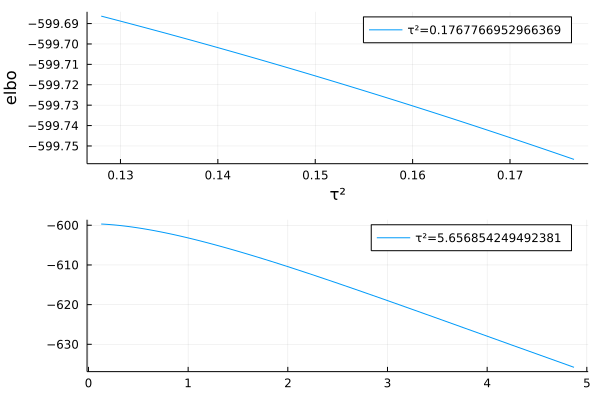

In [97]:
ll=@layout[a ;b]
p1=plot(tau16[:,1],tau16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo")
p2=plot(tau[:,1],tau[:,2],label="τ²=$(τ²[end])")
plot(p1,p2,layout=ll)

### Plots using empirical grm

Regardless of initial values of τ², both elbo and τ² blow out.  

In [149]:
#pick up three initials : τ² = 0.0009765625, 0.125, 5.657
#dropping Inf, NaN
taug1=readdlm("glmm_est_$(τ²[1])_grm.txt")[1:end-2,[2,end]];
taug15=readdlm("glmm_est_$(τ²[15])_grm.txt")[1:end-1,[2,end]];
taug=readdlm("glmm_est_$(τ²[end])_grm.txt")[1:end-1,[2,end]];

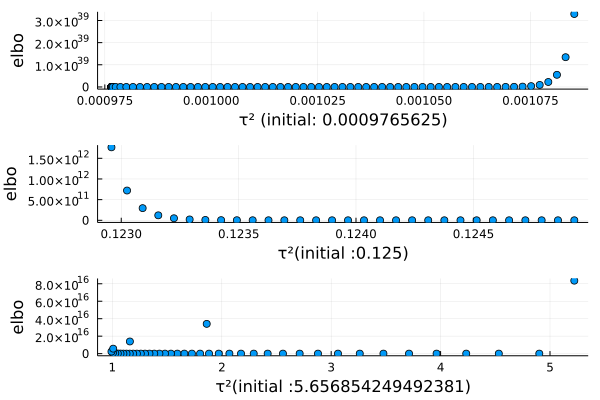

In [183]:
l2=@layout[a; b; c]
pp1=scatter(taug1[1:100,1],taug1[1:100,end],label="",ylab="elbo",xlab="τ² (initial: $(τ²[1]))")
pp2=scatter(taug15[1:30,1],taug15[1:30,end],label="",ylab="elbo",xlab="τ²(initial :$(τ²[15]))")
pp3=scatter(taug[1:42,1],taug[1:42,end],label="",ylab="elbo",xlab="τ²(initial :$(τ²[end]))")
plot(pp1,pp2,pp3,layout=l2)

## GLMM (integration out)

In [132]:


# for j=1:B
#     Xt, Xt₀, yt,init01= initialization(Y,X,ones(n,1),Matrix(1.0I,n,n),ones(n);tol=1e-4)
#     T1= computeT(init01,yt,Xt₀,Xt)
    
         Σ0= 2(cov(Xt₀)+I) # avoid sigularity when only with intercept
     for j in eachindex(τ²)

        sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀)
        β̂0=SuSiEGLMM.getXy('N',sig0,y1)
        ξ0 =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β̂0 ).^2+ Diagonal(SuSiEGLMM.getXX('N',Xt₀,'N',sig0).+τ²[j]*S)*ones(n))
    

        init= SuSiEGLMM.init(y1,Xt₀,S,ξ0,τ²[j],Σ0;tol=tol)
        out1=readdlm(joinpath(@__DIR__,"est_elbocomp.txt"))
#         writedlm("est_elbocomp_$(τ²[j]).txt",out1)
        writedlm("est_elbocomp_$(τ²[j])_grm.txt",out1)
    end
    
#      init1=[init1;init01]
# init1=[init1;init01]
#       Ts1[:,j]=T1;
# end

17
17
17
17
17
17
17
17
17
17
17
17
17
17
16
15
571
687
749
784
805
817
826
832
837
842


In [134]:
Σ0;sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀);
        β̂0=SuSiEGLMM.getXy('N',sig0,y1) #initial β̂

1-element Vector{Float64}:
 110.00000000000047

### Plots of results using pedigree K

Here are arrays of all outputs for tracking τ² and elbo such that initial τ² are smaller and closer to the true `τ2=0.1`.  They converge too early for smaller values or quickly for closer value to the true (strictly speaking, slightly larger than the true τ2)

In [99]:
#track τ² and the corresponding elbo for pedigree K
# early convergence up to initial values close to the true one (max # of iterations: 4)
for j=1:8
display(readdlm("est_elbocomp_$(τ²[2j-1]).txt")[:,[1, end]])
end

4×2 Matrix{Float64}:
 0.000976734  -603.98
 0.000976735  -602.916
 0.000976736  -602.916
 0.000976737  -602.916

4×2 Matrix{Float64}:
 0.00195381  -603.979
 0.00195382  -602.916
 0.00195382  -602.916
 0.00195382  -602.916

4×2 Matrix{Float64}:
 0.003909    -603.979
 0.00390901  -602.916
 0.00390902  -602.916
 0.00390903  -602.916

4×2 Matrix{Float64}:
 0.00782348  -603.978
 0.00782354  -602.916
 0.00782356  -602.916
 0.00782358  -602.916

4×2 Matrix{Float64}:
 0.0156689  -603.977
 0.015669   -602.915
 0.015669   -602.915
 0.015669   -602.915

4×2 Matrix{Float64}:
 0.0314251  -603.976
 0.031425   -602.917
 0.0314244  -602.917
 0.0314237  -602.917

4×2 Matrix{Float64}:
 0.0631967  -603.982
 0.0631915  -602.927
 0.0631839  -602.927
 0.0631763  -602.927

4×2 Matrix{Float64}:
 0.127759  -604.024
 0.127699  -602.978
 0.127629  -602.978
 0.12756   -602.978

In [111]:
#pick the next larger τ² from the true and the largest 
# :τ²=0.17677, 5.65685
t16=readdlm("est_elbocomp_$(τ²[16]).txt")[:,[1,end]];
tm=readdlm("est_elbocomp_$(τ²[end]).txt")[:,[1,end]];


In [135]:
[t16[end-5:end,:] tm[end-5:end,:]] #print out last values up to convergence

6×4 Matrix{Float64}:
 0.137305  -602.988  0.137277  -602.988
 0.137219  -602.988  0.13719   -602.988
 0.137132  -602.988  0.137103  -602.988
 0.137045  -602.988  0.137017  -602.988
 0.136959  -602.988  0.13693   -602.988
 0.136873  -602.988  0.136844  -602.988

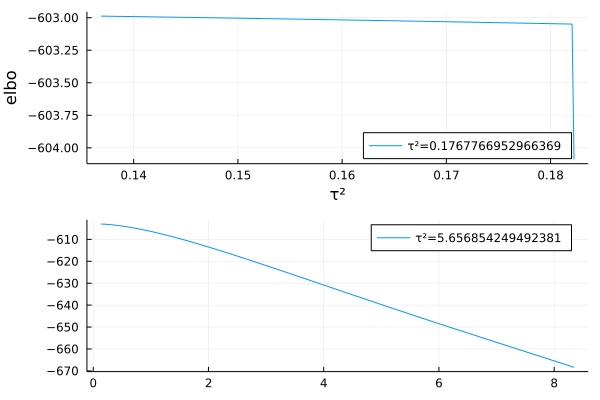

In [108]:
ll=@layout[a ;b]
p3=plot(t16[:,1],t16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo",legend=:bottomright)
p4=plot(tm[:,1],tm[:,2],label="τ²=$(τ²[end])")
plot(p3,p4,layout=ll)

### Plots using empirical grm

Just as results from using the pedigree K, regardless of initial values of `τ²`, all elbo's converge to the almost similar final values. 

In [238]:
#print out last several ouputs of τ²'s and elbo's for small initial τ² less than the true τ2=0.1
for j=2:14
    display(readdlm("est_elbocomp_$(τ²[j])_grm.txt")[end-5:end,[1,end]])
end

6×2 Matrix{Float64}:
 0.00138109  -434.172
 0.00138109  -434.174
 0.00138109  -434.175
 0.00138109  -434.175
 0.00138109  -434.176
 0.00138109  -434.176

6×2 Matrix{Float64}:
 0.00195316  -434.172
 0.00195316  -434.174
 0.00195317  -434.175
 0.00195317  -434.175
 0.00195317  -434.175
 0.00195318  -434.175

6×2 Matrix{Float64}:
 0.0027622   -434.172
 0.00276221  -434.174
 0.00276221  -434.175
 0.00276222  -434.175
 0.00276223  -434.175
 0.00276223  -434.175

6×2 Matrix{Float64}:
 0.00390637  -434.172
 0.00390638  -434.174
 0.0039064   -434.175
 0.00390641  -434.175
 0.00390642  -434.175
 0.00390643  -434.175

6×2 Matrix{Float64}:
 0.00552449  -434.171
 0.00552451  -434.173
 0.00552453  -434.174
 0.00552455  -434.175
 0.00552457  -434.175
 0.00552459  -434.175

6×2 Matrix{Float64}:
 0.00781287  -434.171
 0.0078129   -434.173
 0.00781294  -434.174
 0.00781297  -434.174
 0.007813    -434.174
 0.00781304  -434.174

6×2 Matrix{Float64}:
 0.0110491  -434.171
 0.0110491  -434.173
 0.0110492  -434.174
 0.0110492  -434.174
 0.0110493  -434.174
 0.0110493  -434.174

6×2 Matrix{Float64}:
 0.0156255  -434.17
 0.0156255  -434.172
 0.0156256  -434.173
 0.0156256  -434.174
 0.0156257  -434.174
 0.0156257  -434.174

6×2 Matrix{Float64}:
 0.0220965  -434.17
 0.0220964  -434.172
 0.0220963  -434.173
 0.0220963  -434.173
 0.0220962  -434.174
 0.0220962  -434.174

6×2 Matrix{Float64}:
 0.0312442  -434.171
 0.0312437  -434.173
 0.0312432  -434.174
 0.0312427  -434.174
 0.0312421  -434.174
 0.0312416  -434.174

6×2 Matrix{Float64}:
 0.0441702  -434.174
 0.044168   -434.176
 0.0441658  -434.177
 0.0441637  -434.177
 0.0441615  -434.177
 0.0441593  -434.177

6×2 Matrix{Float64}:
 0.0624178  -434.181
 0.0624104  -434.183
 0.0624029  -434.184
 0.0623955  -434.184
 0.062388   -434.184
 0.0623806  -434.184

6×2 Matrix{Float64}:
 0.0881311  -434.197
 0.0881079  -434.199
 0.0880846  -434.199
 0.0880614  -434.2
 0.0880382  -434.2
 0.088015   -434.2

In [233]:
# pick up initials τ²:
tg1=readdlm("est_elbocomp_$(τ²[1])_grm.txt")[:,[1,end]];
tg15=readdlm("est_elbocomp_$(τ²[15])_grm.txt")[:,[1,end]];
tg16=readdlm("est_elbocomp_$(τ²[16])_grm.txt")[:,[1,end]];
tg17=readdlm("est_elbocomp_$(τ²[17])_grm.txt")[:,[1,end]];
tg2=readdlm("est_elbocomp_$(τ²[end-3])_grm.txt")[:,[1,end]];
tg0=readdlm("est_elbocomp_$(τ²[end-2])_grm.txt")[:,[1,end]];
tg=readdlm("est_elbocomp_$(τ²[end])_grm.txt")[:,[1,end]];

In [230]:
# initial τ²'s selected
τ²[[1,15,16,17,end-3,end-2,end]]

7-element Vector{Float64}:
 0.0009765625
 0.125
 0.1767766952966369
 0.25
 2.0
 2.8284271247461903
 5.656854249492381

In [240]:
# the first four cases selected above
[tg1[end-5:end,:] tg15[end-5:end,:] tg16[end-5:end,:] tg17[end-5:end,:]] 

6×8 Matrix{Float64}:
 0.000976572  -434.172  0.124308  -434.225  …  -434.282  0.132854  -434.244
 0.000976572  -434.174  0.124239  -434.23      -434.294  0.13277   -434.244
 0.000976573  -434.175  0.124171  -434.232     -434.299  0.132686  -434.244
 0.000976574  -434.175  0.124102  -434.233     -434.3    0.132602  -434.244
 0.000976575  -434.176  0.124034  -434.233     -434.301  0.132519  -434.243
 0.000976576  -434.176  0.123966  -434.233  …  -434.301  0.132435  -434.243

In [234]:
[tg2[end-5:end,:] tg0[end-5:end,:] tg[end-5:end,:]] # the last three cases selected

6×6 Matrix{Float64}:
 0.132842  -434.244  0.132859  -434.244  0.132839  -434.244
 0.132758  -434.244  0.132775  -434.244  0.132755  -434.244
 0.132674  -434.244  0.132691  -434.244  0.132671  -434.244
 0.13259   -434.244  0.132607  -434.244  0.132587  -434.244
 0.132507  -434.243  0.132524  -434.243  0.132504  -434.243
 0.132423  -434.243  0.13244   -434.243  0.13242   -434.243

The following three subplots show elbo decreases, but the final values converge to the elbos optimized by large initial τ² cases.


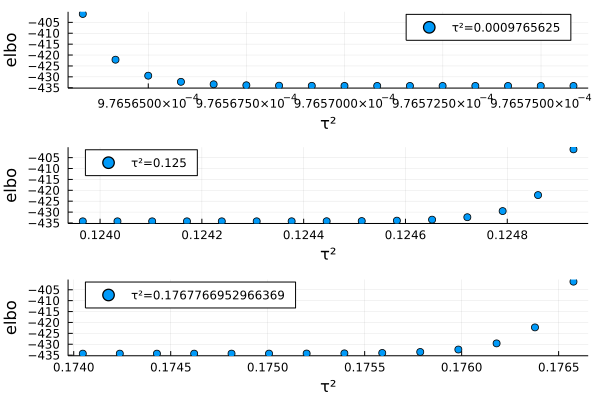

In [216]:
l3=@layout[a; b;c]
pp4=scatter(tg1[:,1],tg1[:,2],label="τ²=$(τ²[1])", xlab="τ²", ylab="elbo")
pp5=scatter(tg15[:,1],tg15[:,2],label="τ²=$(τ²[15])", xlab="τ²", ylab="elbo",legend=:topleft)
pp6=scatter(tg16[:,1],tg16[:,2],label="τ²=$(τ²[16])", xlab="τ²", ylab="elbo",legend=:topleft)
plot(pp4,pp5,pp6,layout=l3)

The following case hard to recognize how elbo changes when τ² reaches the true `τ2=0.1`, so that the first and second halves are separated to display.  The middle plot shows increase to the max elbo after decrease from the large initial value.

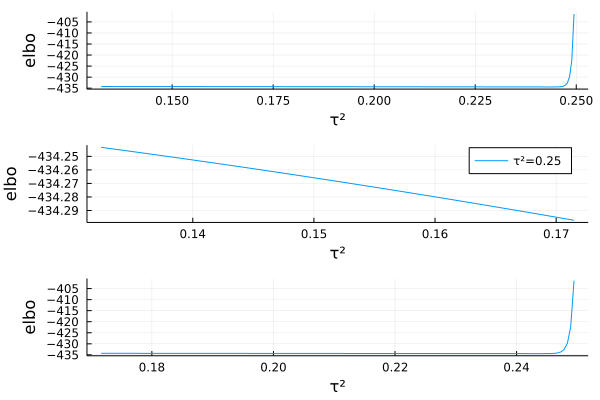

In [228]:
r1=plot(tg17[:,1],tg17[:,2],label="", xlab="τ²", ylab="elbo") 
r=plot(tg17[1:250,1],tg17[1:250,2],label="", xlab="τ²", ylab="elbo") 
r2=plot(tg17[251:end,1],tg17[251:end,2],label="τ²=$(τ²[17])", xlab="τ²", ylab="elbo")
plot(r1,r2,r,layout=@layout[a; b; c])

Sufficiently large initial τ²'s dramatically dropped down to min and started to reach the max elbo while approacing to the true `τ2=0.1`.

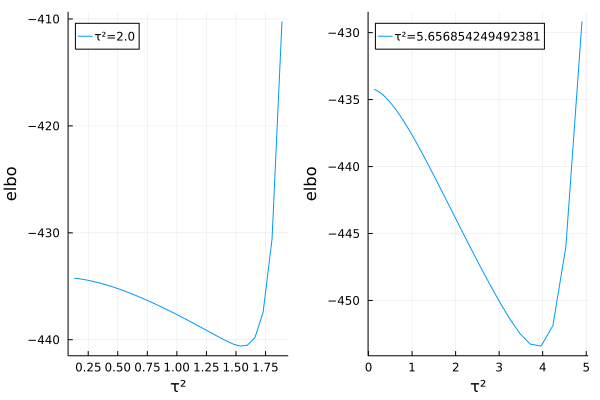

In [226]:
pp10=plot(tg2[:,1],tg2[:,2],label="τ²=$(τ²[end-3])",xlab="τ²", ylab="elbo",legend=:topleft)
# pp8= plot(tg0[:,1],tg0[:,2],label="τ²=$(τ²[end-2])",xlab="τ²", ylab="elbo")
pp9=plot(tg[:,1],tg[:,2],label="τ²=$(τ²[end])",xlab="τ²", ylab="elbo",legend=:topleft)
plot(pp10,pp9,layout=@layout[a b ])